# National Health and Nutrition Examination Survey 
# (NHANES) 2015-2016
Enyel A. Rodríguez G. — Febrero 2024

----------

NHANES is a study program designed to assess the nutritional status of adults and children in the United States that is conducted annually. NHANES interviews include demographic, socioeconomic, dietary, and health-related questions.

Before executing an analysis plan, it is very important to take into account the characteristics of the sample and the distribution of the data. For example, if we analyze a stratified sample as a simple random sample, there is a risk that our analysis will reflect incorrect parameters and optimistic hypothesis tests that are not representative of the real population.

For demonstrative purposes, we will assume that the NHANES 2015-2016 dataset comes from a simple random sample and the analysis will be conducted under this premise. Subsequently, through regression models, analysis will be performed in the context of a stratified sample.

This notebook shows some capabilities of Python libraries for statistical analysis. You can check the [NHANES codebook](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#Codebook) for a detailed description of the variables contained in the database. To get started, after importing the csv file, we are going to import several Python libraries that will be useful for the analysis.

In [ ]:
# Creates a list of files on Google Drive's directory
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

# This is the current directory where the csv file resides
%cd My\ Drive/Colab/Portfolio/NHANES\ 2015-2016
%ls

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import add_lowess
import scipy.stats
import seaborn as sns

da = pd.read_csv("nhanes_2015_2016.csv")

# Prints a list of columns from the dataframe
print(da.columns)

# Prints the size of the dataframe (rows, columns)
da.shape

Index(['SEQN', 'ALQ101', 'ALQ110', 'ALQ130', 'SMQ020', 'RIAGENDR', 'RIDAGEYR',
       'RIDRETH1', 'DMDCITZN', 'DMDEDUC2', 'DMDMARTL', 'DMDHHSIZ', 'WTINT2YR',
       'SDMVPSU', 'SDMVSTRA', 'INDFMPIR', 'BPXSY1', 'BPXDI1', 'BPXSY2',
       'BPXDI2', 'BMXWT', 'BMXHT', 'BMXBMI', 'BMXLEG', 'BMXARML', 'BMXARMC',
       'BMXWAIST', 'HIQ210'],
      dtype='object')


(5735, 28)

## Descriptive statistics

----------

We can obtain descriptive statistics from the dataset on the quantitative variables age ([RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)), weight ([BMXWT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXWT)), height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) and body mass index ([BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)) using `describe()`.

In [3]:
# Describes the variables RIDAGEYR, BMXWT, BMXHT, BMXBMI
da[["RIDAGEYR", "BMXWT", "BMXHT", "BMXBMI"]].describe()

,RIDAGEYR,BMXWT,BMXHT,BMXBMI
count,5735.000000,5666.000000,5673.000000,5662.000000
mean,48.052310,81.342676,166.142834,29.382197
std,18.431011,21.764409,10.079264,7.095921
min,18.000000,32.400000,129.700000,14.500000
25%,32.000000,65.900000,158.700000,24.300000
50%,48.000000,78.200000,166.000000,28.300000
75%,63.000000,92.700000,173.500000,33.000000
max,80.000000,198.900000,202.700000,67.300000


The mean age of this dataset is 48.1  years, with a standard deviation of $\pm$ 18.4 years, with a minimum of 18 years and a maximum of 80 years. We can also see the values of the first and third quartiles for age ([RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)). The aforementioned parameters can also be seen for weight ([BMXWT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXWT)), height ([BMXHT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXHT)) and body mass index ([BMXBMI](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXBMI)).

We can create a histogram of the weight ([BMXWT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXWT)) distribution with the seaborn library, for the complete dataset and also separating it by gender ([RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)).

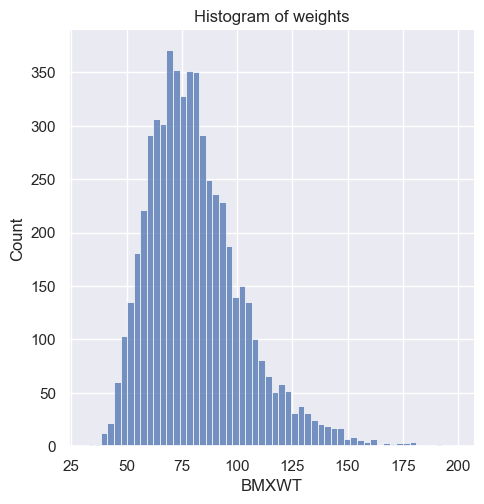

In [4]:
sns.set_theme()
sns.displot(da["BMXWT"].dropna()).set(title='Histogram of weights')

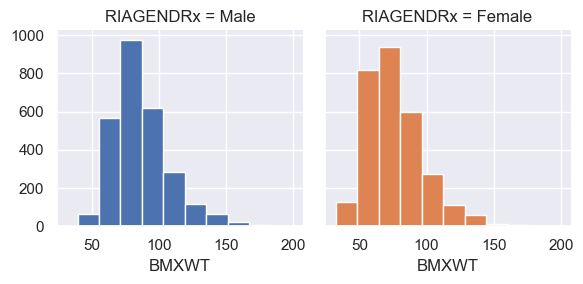

[Text(0.5, 1.0, 'Box plot of weights by gender')]

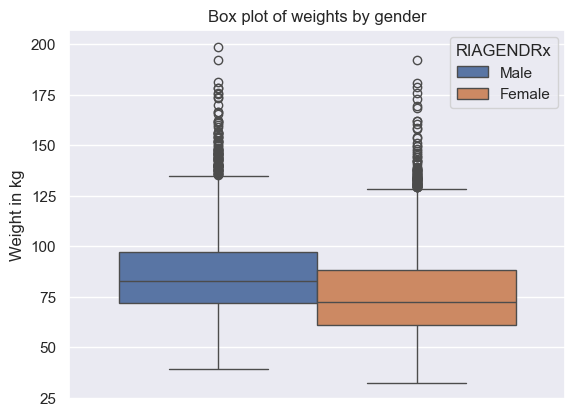

In [5]:
# Relabels the gender variable
da["RIAGENDRx"] = da["RIAGENDR"].replace({1: "Male", 2: "Female"})

dataset_plot = sns.FacetGrid(da, col="RIAGENDRx", hue="RIAGENDRx")
dataset_plot = dataset_plot.map(plt.hist, "BMXWT")
plt.show()

dataset_box = sns.boxplot(y="BMXWT", data=da, hue="RIAGENDRx")
dataset_box.set_ylabel("Weight in kg")
dataset_box.set(title="Box plot of weights by gender")

The histogram of weight for the entire sample is skewed to the right, with no marked differences in distribution between genders. In the box plot we can see that the mean weight in men is higher than in women.

We can also build frequency tables of household size for people in each race/ethnic origin category ([RIDRETH1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDRETH1)).

In [6]:
# Relabels the race/hispanic origin variable
da["RIDRETH1x"] = da["RIDRETH1"].replace({1: "Mexican American", 2: "Other Hispanic", 3: "Non-Hispanic White", 4: "Non-Hispanic Black", 5: "Other Race"})
da.groupby(["RIDRETH1x"])["DMDHHSIZ"].value_counts(normalize=True).unstack()

DMDHHSIZ,1,2,3,4,5,6,7
RIDRETH1x,,,,,,,
Mexican American,0.054028,0.191552,0.177800,0.181729,0.151277,0.120825,0.122790
Non-Hispanic Black,0.171149,0.248574,0.181744,0.147514,0.116544,0.061940,0.072535
Non-Hispanic White,0.194127,0.361066,0.159869,0.133225,0.091898,0.037520,0.022295
Other Hispanic,0.090667,0.214667,0.188000,0.208000,0.153333,0.085333,0.060000
Other Race,0.088790,0.245283,0.219756,0.187569,0.130966,0.052164,0.075472


Non-Hispanic whites have the highest proportion of 2-person households of all other race/Hispanic origin categories. We can see how the proportions for the Mexican-American and Other Hispanic categories have similar frequencies between household sizes of 2 to 4 compared to other race/Hispanic origin categories.

We can build a table stratified by a combination of race/Hispanic origin ([RIDRETH1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDRETH1)) and gender ([RIAGENDR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIAGENDR)), to see any difference in the means of age ([RIDAGEYR](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDAGEYR)), weight ([BMXWT](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BMX_I.htm#BMXWT)) and first systolic blood pressure measurements ([BPXSY1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/BPX_I.htm#BPXSY1)).

In [7]:
da.groupby(["RIDRETH1x", "RIAGENDRx"])[["RIDAGEYR", "BMXWT", "BPXSY1"]].mean().unstack()

RIDAGEYR                 BMXWT                 BPXSY1  \
RIAGENDRx              Female       Male     Female       Male      Female   
RIDRETH1x                                                                    
Mexican American    46.173112  46.395789  77.350000  86.079095  121.905697   
Non-Hispanic Black  46.287250  47.144097  83.896734  89.095760  125.786311   
Non-Hispanic White  50.898901  52.404736  77.221397  90.093333  123.122685   
Other Hispanic      48.971963  48.298137  74.429176  85.954206  125.071605   
Other Race          44.479730  43.586433  65.314286  77.256291  119.826303   

                                
RIAGENDRx                 Male  
RIDRETH1x                       
Mexican American    126.926407  
Non-Hispanic Black  131.007463  
Non-Hispanic White  126.242152  
Other Hispanic      127.132686  
Other Race          123.488152

Across race/Hispanic origin categories, the highest mean age corresponds to non-Hispanic whites; the highest mean weight corresponds to both non-Hispanic whites and non-Hispanic blacks; the highest mean of the first systolic blood pressure measurement corresponds to non-Hispanic blacks.

We see a notable difference between men and women for the mean weight (non-Hispanic whites present the largest difference with 13.1 kg) and systolic blood pressure measurements (non-Hispanic blacks present the largest difference with 5.2). No particularly noteworthy difference in the age variable is observed between race/Hispanic origin categories.

We can construct scatter plots to compare the distribution of height and weight by race/Hispanic origin categories (columns) and gender (rows).

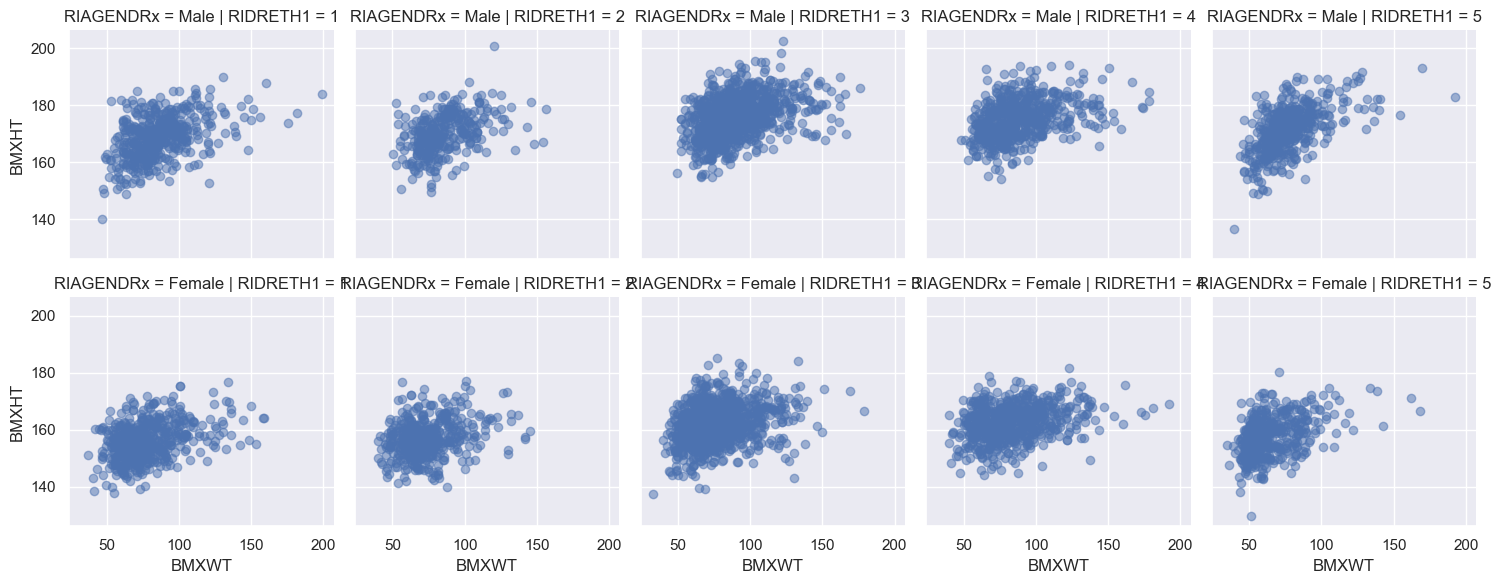

In [8]:
sns.FacetGrid(da, col="RIDRETH1", row="RIAGENDRx").map(plt.scatter, "BMXWT", "BMXHT", alpha=0.5).add_legend()

There is a difference in the weight and height distributions between men and women in the race/Hispanic origin categories, with no notable differences between each race/Hispanic origin category. We can observe how non-Hispanic whites and non-Hispanic blacks have a higher weight variance than other race/Hispanic origin categories.

We can create violin plots to compare the distribution of the first systolic blood pressure measurements within a series of 10-year age ranges, stratified by gender.

<Axes: xlabel='agegrp', ylabel='BPXSY1'>

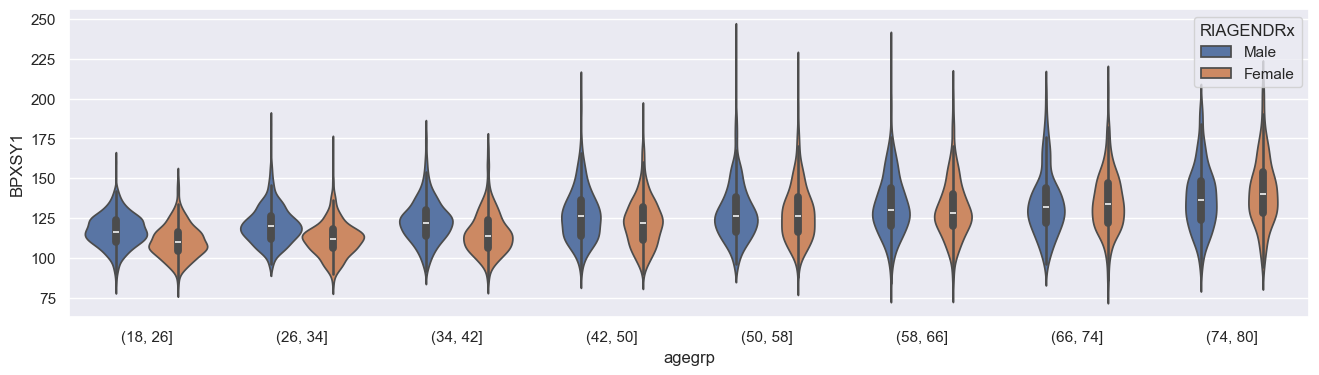

In [9]:
# Stratifies the age into 10 year intervals
da["agegrp"] = pd.cut(da.RIDAGEYR, [18, 26, 34, 42, 50, 58, 66, 74, 80])
plt.figure(figsize=(16, 4))
sns.violinplot(da, x="agegrp", y="BPXSY1", hue="RIAGENDRx")

Across the 10-year age bands there is an upward trend in the means of the first systolic blood pressure measurements as age increases, with higher variance as well. Males have higher average first systolic blood pressure measurements than females on the lower end of age, but the difference narrows as age increases, with a reversal of this proportion in the oldest age band.

## Inferential analysis

----------

We can determine the proportions and their 95% confidence intervals (95% CI) of men and women who smoke ([SMQ020](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/SMQ_I.htm#SMQ020)), as well as the 95% CI for the difference between gender proportions.

In [10]:
# Prepares the data, selecting by gender and smoking habits
females = da.query('RIAGENDR == 2')
males = da.query('RIAGENDR == 1')
female_smokers = females['SMQ020'] == 1
male_smokers = males['SMQ020'] == 1

# Function that calculates the IC for proportions
def ProportionsCI(data, confidence):
    p_hat = np.mean(data)
    n = data.size
    z_multiplier = scipy.stats.norm.ppf(q = 1 - (1 - confidence) / 2)
    standard_error = np.sqrt(p_hat * (1 - p_hat) / n)
    lower_bound = p_hat - z_multiplier * standard_error
    upper_bound = p_hat + z_multiplier * standard_error
    return {"p_hat": p_hat, "n":n, "lower_bound":lower_bound, "upper_bound":upper_bound}

# Calculates the proportion of women who smoke with their 95% CI
female_smokers_ci = ProportionsCI(female_smokers, 0.95)
print("The proportion and CI for women who smoke is (N={}) is {:.2f} ({:.2f}, {:.2f})".format(
    female_smokers_ci['n'],
    female_smokers_ci['p_hat'],
    female_smokers_ci['lower_bound'],
    female_smokers_ci['upper_bound']
))

# Calculates the proportion of men who smoke with their 95% CI
male_smokers_ci = ProportionsCI(male_smokers, 0.95)
print("The proportion and CI for men who smoke is (N={}) is {:.2f} ({:.2f}, {:.2f})".format(
    male_smokers_ci['n'],
    male_smokers_ci['p_hat'],
    male_smokers_ci['lower_bound'],
    male_smokers_ci['upper_bound']
))

# Construct the CI for the difference in proportions

# Calculates the standar error by difference
standard_error = np.sqrt(
    female_smokers_ci['p_hat'] * (1 - female_smokers_ci['p_hat']) / female_smokers_ci['n'] + 
    male_smokers_ci['p_hat'] * (1 - male_smokers_ci['p_hat']) / male_smokers_ci['n']
)

# Calculates the z-multiplier for the 95% CI
z_multiplier = scipy.stats.norm.ppf(q = 0.975)

# Calculates the difference in proportions between men and women who smoke
difference = male_smokers_ci['p_hat'] - female_smokers_ci['p_hat']

# Calculates the upper and lower bounds for the 95% CI
lower_bound = difference - z_multiplier * standard_error
upper_bound = difference + z_multiplier * standard_error
print("The difference in proportions and 95% CI between men and women is {:.2f} ({:.2f}, {:.2f})".format(
  difference,
  lower_bound,
  upper_bound
))

The proportion and CI for women who smoke is (N=2976) is 0.30 (0.29, 0.32)
The proportion and CI for men who smoke is (N=2759) is 0.51 (0.49, 0.53)
The difference in proportions and 95% CI between men and women is 0.21 (0.18, 0.23)


We observe that the proportion of men who smoke (51%, 95% CI: 49-53%) is higher than the proportion of women who smoke (30%, 95%CI: 29-32%), with no intersection of the 95% confidence intervals. The difference between these proportions is 21%, 95% CI: 18-23%. These results provide evidence that this difference in proportions could be statistically significant.

To confirm this possibility, it is also important to conduct a hypothesis test. Before conducting our hypothesis test, it is important to establish our null hypothesis and significance level. In this case, our null hypothesis is "there is no difference between the cigarette smoking proportion between genders" with a significance level of 5% (0.05).

In [11]:
# Removes empty or non-valid data
da["RIAGENDRx"] = da.RIAGENDR.replace({1: "Male", 2: "Female"})
da["SMQ020x"] = da.SMQ020.replace({1: "Yes", 2: "No", 7: np.nan, 9: np.nan})
dx = da[["SMQ020x", "RIAGENDRx"]].dropna()

# Returns the frequency of smokers by gender
print("There are {} men, of which {} smoke".format(len(males), male_smokers.sum()))
print("There are {} women, of which {} smoke".format(len(females), female_smokers.sum()))

# Returns the proportion of smokers by gender
print("The proportion of men who smoke is {:.2f} while".format(male_smokers_ci['p_hat']))
print("the proportion of women who smoke is {:.2f}".format(female_smokers_ci['p_hat']))

# Filters the dataframes by gender and relabels the Yes/No to 1/0 for the hypothesis test
smoker_females = dx.loc[dx["RIAGENDRx"] == "Female", "SMQ020x"].replace({"Yes": 1, "No": 0})
smoker_males = dx.loc[dx["RIAGENDRx"] == "Male", "SMQ020x"].replace({"Yes": 1, "No": 0})
ztest = sm.stats.ztest(smoker_males, smoker_females)
print("Z-test for difference in proportions: z = {:.2f}, p = {:.5e}".format(ztest[0], ztest[1]))

There are 2759 men, of which 1413 smoke
There are 2976 women, of which 906 smoke
The proportion of men who smoke is 0.51 while
the proportion of women who smoke is 0.30
Z-test for difference in proportions: z = 16.42, p = 1.36246e-60


We observe that the z-statistic is equal to 16.42, which means that this observed difference deviates 16.42 standard errors, an extreme difference to observe assuming the null hypothesis (no gender difference exists) is true. The p-value for this test is 1.36246e-60 or p<0.05. Since the p-value is less than our significance level, we reject the null hypothesis and have evidence in favor of a difference in cigarette smoking proportions between genders.

We can calculate the 95% CI for the mean of the first and second systolic blood pressure of each individual between the ages of 50 to 60 years. Considering these are repeated measurements of the same individuals, the paired t-test is the test of choice to determine if the difference between the mean blood pressures is statistically significant.

In this case our null hypothesis is "there is no difference between the first and second blood pressure measurements among individuals ages 50 to 60 years".

In [12]:
# Filter the data to the ages 50 to 60
crit = da.loc[(da["RIDAGEYR"] >=50) & (da["RIDAGEYR"] <=60)]

# Calculates the mean and 95% CI for the first systolic blood pressure measurement (BPXSY1)
sbp1 = crit["BPXSY1"].dropna()
sbp1_ci = sm.stats.DescrStatsW(sbp1).zconfint_mean()
print("The 95% CI for the first systolic blood pressure measurement is: {:.2f} ({:.2f}, {:.2f})".format(
        sbp1.mean(),
        sbp1_ci[0], 
        sbp1_ci[1]
    ))

# Calculates the mean and 95% CI for the second systolic blood pressure measurement (BPXSY2)
sbp2 = crit["BPXSY2"].dropna()
sbp2_ci = sm.stats.DescrStatsW(sbp2).zconfint_mean()
print("The 95% CI for the second systolic blood pressure measurement is: {:.2f} ({:.2f}, {:.2f})".format(
        sbp2.mean(),
        sbp2_ci[0], 
        sbp2_ci[1]
    ))

# Calculates the difference between the systolic blood pressure measurements
se_sbp1 = sbp1.std()/np.sqrt(len(sbp1)) 
se_sbp2 = sbp2.std()/np.sqrt(len(sbp2))
se_diff = np.sqrt(se_sbp1**2 + se_sbp2**2)
mean_diff = sbp1.mean() - sbp2.mean()
lcb_diff = mean_diff - 1.96*se_diff
ucb_diff = mean_diff + 1.96*se_diff

print("The 95% CI for the difference between the first and second systolic blood pressure measurement is: {:.2f} ({:.2f}, {:.2f})".format(
        mean_diff,
        lcb_diff, 
        ucb_diff
    ))

# Selects the rows that contains both first and second systolic blood pressure measurements
dx = crit[crit["BPXSY1"].notnull() & crit["BPXSY2"].notnull()]
first_systolic = dx["BPXSY1"]
second_systolic = dx["BPXSY2"]

# Calculates the paired t-test value
ttest = scipy.stats.ttest_rel(first_systolic, second_systolic)
print("The paired t-test p value is: {:.5e}".format(ttest[1]))

The 95% CI for the first systolic blood pressure measurement is: 128.57 (127.41, 129.74)
The 95% CI for the second systolic blood pressure measurement is: 128.18 (127.03, 129.32)
The 95% CI for the difference between the first and second systolic blood pressure measurement is: 0.40 (-1.24, 2.03)
The paired t-test p value is: 3.52773e-04


We observe that there is a 0.4 mmHg difference between the first and second systolic blood pressure measurements, with a confidence interval that includes 0. Despite our p-value being less than 0.05, we do not have sufficient evidence to reject the null hypothesis ("there is no difference between the first and second blood pressure measurements among individuals ages 50 to 60 years").

## Regression analysis

----------

To perform regression in Python, we first need to prepare our data based on our variables of interest. Afterwards, we can perform linear regression with the first systolic blood pressure measurement as our dependent variable and age in years as the independent variable.

In [13]:
# Creates a dataset with no missing values or empty values to analyze the first systolic blood pressure measurement as the outcome
vars = ["RIDAGEYR", "RIAGENDR", "RIDRETH1", "BPXSY1", "BMXBMI", "SMQ020"]
db = da[vars].dropna()

m0 = sm.OLS.from_formula("BPXSY1 ~ RIDAGEYR", data=db)
r0 = m0.fit()
r0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 BPXSY1   R-squared:                       0.222
Model:                            OLS   Adj. R-squared:                  0.222
Method:                 Least Squares   F-statistic:                     1522.
Date:                Sun, 18 Feb 2024   Prob (F-statistic):          3.09e-293
Time:                        15:15:58   Log-Likelihood:                -22487.
No. Observations:                5347   AIC:                         4.498e+04
Df Residuals:                    5345   BIC:                         4.499e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    102.4739      0.619    165.512      0.000     101.260     103.688
RIDAGEYR       0.4695      0.012     39.017      0.000       0.446       0.493
==============================================================================
Omnibus:                      735.276   Durbin-Watson:                   2.030
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1655.199
Skew:                           0.811   Prob(JB):                         0.00
Kurtosis:                       5.190   Cond. No.                         144.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Through this linear regression, we can observe that for each additional year of age, a 0.5 mmHg increase in blood pressure would be expected. This relationship is statistically significant, since the p-value is less than 0.05.

Other variables of interest could be gender and ethnic origin, which we can analyze taking into account all ages and then dividing these data into two different age groups: People under 50 years old and people 50 years old or older. In this case it is important to take into account the codebook for the ethnic origin variable, [RIDRETH1](https://wwwn.cdc.gov/Nchs/Nhanes/2015-2016/DEMO_I.htm#RIDRETH1).

In [14]:
db["RIAGENDRx"] = db.RIAGENDR.replace({1: "Male", 2: "Female"})
print("All ages:")
m1 = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx + C(RIDRETH1)", data=db)
r1 = m1.fit()
print(r1.summary())

print("\nLess than 50 years old:")
m2 = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx + C(RIDRETH1)", data=db[db.RIDAGEYR<50])
r2 = m2.fit()
print(r2.summary())

print("\nMore or equal to 50 years old:")
m3 = sm.GLM.from_formula("BPXSY1 ~ RIDAGEYR + RIAGENDRx + C(RIDRETH1)", data=db[db.RIDAGEYR>=50])
r3 = m3.fit()
print(r3.summary())

All ages:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                 BPXSY1   No. Observations:                 5347
Model:                            GLM   Df Residuals:                     5340
Model Family:                Gaussian   Df Model:                            6
Link Function:               Identity   Scale:                          255.90
Method:                          IRLS   Log-Likelihood:                -22408.
Date:                Sun, 18 Feb 2024   Deviance:                   1.3665e+06
Time:                        15:15:59   Pearson chi2:                 1.37e+06
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2761
Covariance Type:            nonrobust                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.5983

Considering we have categorical variables in our linear regression model, it is important to identify the references taken by the software. In this case, the intercept corresponds to the "male" category for the gender variable and "Mexican-American" for the ethnic origin variable.

For the age group greater than or equal to 50 years, we observe that the "non-Hispanic black" ethnic origin has a coefficient of 4.2 (95% CI 1.8, 6.7). That is, for individuals of "non-Hispanic black" ethnic origin, the first systolic blood pressure measurement is expected to be 4.2 mmHg higher, adjusted for age and gender. We also observe an age coefficient of 0.5 (95% CI 0.4, 0.6), meaning for each additional year of age the first systolic blood pressure measurement is expected to increase by 0.5 mmHg, adjusted for gender and ethnic origin. Both independent variables are statistically significant, since their p-values are less than 0.05.

For the models taking into account all ages, as well as the group under 50 years, the coefficients for the age variable and "non-Hispanic black" ethnic origin decrease slightly compared to the age group greater than or equal to 50 years but their confidence intervals do not contain 0. This fact, along with the p-values less than 0.05 for these variables, provides enough evidence to reject the null hypothesis.

Notably, the pseudo R-squared of the model taking into account all ages (0.28) is greater than that of the models dividing this sample into age groups greater than or equal to 50 years and less than 50 years (0.07 and 0.17 respectively). This indicates that the model taking into account all ages has a better linear relationship with the first systolic blood pressure measurement.

Considering the model for the over 50 age group, we can estimate the difference in the mean of the first systolic blood pressure measurement for a 70 year old individual versus a 50 year old, adjusting for gender and ethnic origin.

In [15]:
r3.params["RIDAGEYR"] * 20

10.202361066344995

We observe that the difference in the mean of the first systolic blood pressure measurement for a 70 year old and a 50 year old individual is 10.2 mmHg according to this regression model.

For the regression model including all ages, we can make a partial regression plot to assess the linear relationship between the first systolic blood pressure measurement and age, adjusted for sex and ethnic origin.

48.05231037489102


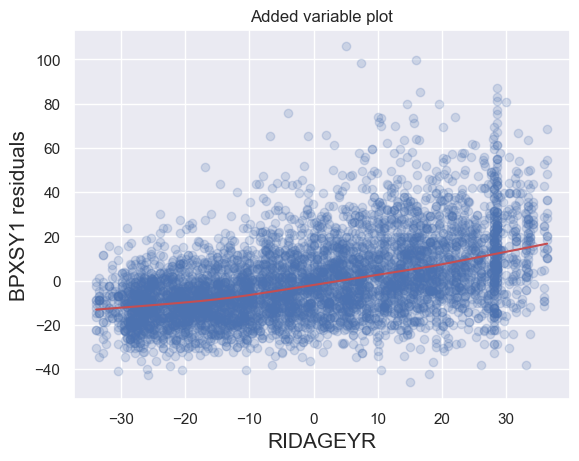

In [20]:
fig = r1.plot_added_variable("RIDAGEYR")
ax = fig.get_axes()[0]
ax.lines[0].set_alpha(0.2)
add_lowess(ax, frac=0.5)
ax.grid(True)
ax.set(title='Added variable plot')
print(da["RIDAGEYR"].mean())

We observe that the relationship between age and the first systolic blood pressure measurement is approximately linear: Before the mean age (48 years) the first systolic blood pressure measurement increases by approximately 14 units per 20 years, after this point the first systolic blood pressure measurement increases by approximately 26 units per 40 years.

Based on this plot for this specific regression model, looking at the distribution of the residuals with the regression line, we see that there is a strong to moderate linear relationship between the first systolic blood pressure measurement and the individuals' age adjusted for gender and ethnic origin.

Up to this point, we have assumed the data comes from simple random sampling. However, NHANES is a stratified clustered sample dataset. This has consequences during analysis, since samples coming from the same cluster are similar to each other. Through a marginal regression model, we can use regression models that take into account these sample characteristics.

This first marginal regression model has no independent variables, in order to estimate the Intraclass Correlation Coefficient (ICC).

In [17]:
# Selects the columns to be used and eliminates the rows with missing values
vars = ["BPXSY1", "RIDAGEYR", "RIAGENDR", "RIDRETH1", "SMQ020", "SDMVSTRA", "SDMVPSU"]
db = da[vars].dropna()

# This is the variable for the groups
db["group"] = 10*db.SDMVSTRA + db.SDMVPSU

# Marginal regression model to determine the Intraclass Correlation Coefficient (ICC)
m4 = sm.GEE.from_formula("BPXSY1 ~ 1", "group", cov_struct=sm.cov_struct.Exchangeable(), data=db)
r4 = m4.fit()
r4.cov_struct.summary()

'The correlation between two observations in the same cluster is 0.030'

Based on the ICC we can conclude that 3% of the variance is between clusters and 97% is within clusters. We can perform a marginal model regression, where the first systolic blood pressure measurement will be our dependent variable and the age, gender and ethnic origin variables will be our independent variables.

In [18]:
db["RIAGENDRx"] = db.RIAGENDR.replace({1: "Male", 2: "Female"})
m5 = sm.GEE.from_formula("BPXSY1 ~ RIAGENDRx + RIDAGEYR + C(RIDRETH1)", "group", cov_struct=sm.cov_struct.Exchangeable(), data=db)
r5 = m5.fit()
r5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               GEE Regression Results                              
===================================================================================
Dep. Variable:                      BPXSY1   No. Observations:                 5401
Model:                                 GEE   No. clusters:                       30
Method:                        Generalized   Min. cluster size:                 111
                      Estimating Equations   Max. cluster size:                 234
Family:                           Gaussian   Mean cluster size:               180.0
Dependence structure:         Exchangeable   Num. iterations:                     9
Date:                     Sun, 18 Feb 2024   Scale:                         258.784
Covariance type:                    robust   Time:                         15:16:03
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           100.9729      0.949    106.405      0.000      99.113     102.833
RIAGENDRx[T.Male]     3.5625      0.414      8.596      0.000       2.750       4.375
C(RIDRETH1)[T.2]      0.1739      0.716      0.243      0.808      -1.229       1.577
C(RIDRETH1)[T.3]     -2.5784      0.747     -3.454      0.001      -4.042      -1.115
C(RIDRETH1)[T.4]      3.2063      0.825      3.887      0.000       1.590       4.823
C(RIDRETH1)[T.5]     -1.3434      0.794     -1.693      0.091      -2.899       0.212
RIDAGEYR              0.4698      0.018     26.244      0.000       0.435       0.505
==============================================================================
Skew:                          0.8461   Kurtosis:                       2.3364
Centered skew:                 0.8327   Centered kurtosis:              2.2624
==============================================================================
"""

If we compare this marginal regression model to the previous linear regression model with the same variables and taking into account all ages, we observe that there is greater variance in many of the regression coefficients (evidenced by the higher standard error values).

Notably, the coefficient for the "other ethnicities, including multi-ethnic" ethnic origin has a 95% CI that includes 0 and a p-value of 0.05 in this marginal regression model, while in the previous linear model the 95% CI did not include 0 and showed a p-value less than 0.05. This is an example of the importance of taking into account the sample design prior to conducting our analysis, since we could interpret the results very optimistically and arrive at incorrect conclusions.

In [19]:
r5.cov_struct.summary()

'The correlation between two observations in the same cluster is 0.013'

When determining the ICC with this new model, we observe that the added variables are factors that can explain 1% of the variance between clusters and 99% within clusters. This means the independent variables are not distributed approximately equally at all cluster levels.